<a href="https://colab.research.google.com/github/H-haruki-20/MODNet/blob/main/MODNet_WebCam_Based_Video_Matting_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODNet - WebCam-Based Portrait Video Matting Demo

[![arXiv](https://img.shields.io/badge/arXiv-Paper-<COLOR>.svg)](https://arxiv.org/pdf/2011.11961.pdf)          [![GitHub stars](https://img.shields.io/github/stars/ZHKKKe/MODNet?style=social)](https://github.com/ZHKKKe/MODNet)

<p align="justify">This is a <b>WebCam-Based Portrait Video Matting Demo</b> of our paper ''<a href="https://arxiv.org/pdf/2011.11961.pdf">Is a Green Screen Really Necessary for Real-Time Portrait Matting?</a>''. We propose a trimap-free MODNet for portrait matting in real time (on a single GPU). If you want to perform matting for portrait images, please refer to our <b>Portrait Image Matting Demo</b> [<a href="https://colab.research.google.com/drive/1GANpbKT06aEFiW-Ssx0DQnnEADcXwQG6?usp=sharing">colab</a>].

<!-- <img src="https://raw.githubusercontent.com/ZHKKKe/MODNet/develop/doc/gif/image_matting_demo.gif" width="40%"> -->

<p align="justify"> We use ~400 unlabeled video clips (divided into ~50,000 unlabeled frames) downloaded from the internet to perform SOC to adapt MODNet to the video domain. Nonetheless, <b><font color='#FF000'>due to insufficient labeled training data (~3k labeled foregrounds), our model may still make errors in portrait semantics estimation under challenging scenes</font></b>.

Please run the code step by step to call your WebCam for real-time portrait video matting.
Note that <b><font color='#FF000'>due to Colab resource limitations, the fps of this demo is very low</font></b> (It is also based on your network status). If you have an Ubuntu system with WebCam, please consider trying our <a href="https://github.com/ZHKKKe/MODNet/tree/master/demo/video_matting">offline demo</a> to get a higher <i>fps</i>.

For a better experience, please:

*   use a supported browser (Google Chrome is recommended) and allow third-party cookies (used to call WebCam)
*   make sure the network is in good condition
*   make sure the portrait and background are distinguishable, <i>i.e.</i>, are not similar
*   run in soft and bright ambient lighting
*   do not be too close or too far from the WebCam
*   do not move too fast

By the way, if you have any suggestions on improving the efficiency of executing JS scripts in Colab, <i>i.e.</i>, to make this demo have a higher <i>fps</i>, please let me know. Thanks in advance!
</p>

### **Let's start!**

## 1. Preparation

<p align="justify">In the top menu of this session, select <b>Runtime -> Change runtime type</b>, and set <b>Hardware Accelerator</b> to <b>GPU</b>.</p>

<p align="justify">Clone the repository, and download the pre-trained model:</p>


In [15]:
import os

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/ZHKKKe/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for video matting
pretrained_ckpt = 'pretrained/modnet_webcam_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1Nf1ZxeJZJL8Qx9KadcYYyEmmlKhTADxX \
          -O pretrained/modnet_webcam_portrait_matting.ckpt


/content
/content/MODNet


Define JS script to call WebCam:

In [16]:
import io
import base64
from google.colab.output import eval_js
from IPython.display import display, Javascript


def prepare_webcam():
  display(
    Javascript('''
      var div = null;
      var video;
      var stream;
      var imgElement;
      var captureCanvas;
      var pendingResolve = null;

      async function onAnimationFrame() {
        window.requestAnimationFrame(onAnimationFrame);

        if (pendingResolve) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          var result = captureCanvas.toDataURL('image/jpeg', 0.8);

          var lp = pendingResolve;
          pendingResolve = null;
          lp(result);
        }
      }

      async function initWebCam() {
        div = document.createElement('div');
        document.body.appendChild(div);

        video = document.createElement('video');
        video.style.display = 'inline-block';
        stream = await navigator.mediaDevices.getUserMedia(
            {video: { facingMode: "environment"}});
        div.appendChild(video);

        imgElement = document.createElement('img');
        imgElement.style.display = 'inline-block';
        div.appendChild(imgElement);

        video.srcObject = stream;
        await video.play();

        captureCanvas = document.createElement('canvas');
        captureCanvas.width = 640;
        captureCanvas.height = 480;
        window.requestAnimationFrame(onAnimationFrame);

        return stream;
      }

      async function processFrame(fgFrame) {
        if (div == null) {
          stream = await initWebCam();
        }

        if (fgFrame != "") {
          var videoRect = video.getClientRects()[0];
          imgElement.style.top = videoRect.top + "px";
          imgElement.style.left = videoRect.left + "px";
          imgElement.style.width = videoRect.width + "px";
          imgElement.style.height = videoRect.height + "px";
          imgElement.src = fgFrame;
        }

        return await new Promise(
          function(resolve, reject) {pendingResolve = resolve;});
      }
    ''')
  )

def process_frame(fg_frame):
  return eval_js('processFrame("{}")'.format(fg_frame))


Load the pre-trained MODNet and define the inference code:

In [36]:
import io
import PIL
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from src.models.modnet import MODNet


modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet).cuda()
modnet.load_state_dict(torch.load(pretrained_ckpt))
modnet.eval()


torch_transforms = transforms.Compose(
  [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ]
)

# prepare replacement image
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T

file_name = "balloon_replacement.jpeg"
replace_image = read_image(path=file_name)

def modnet_matting(modnet, im_frame):
  im_bytes = base64.b64decode(im_frame.split(',')[1])
  im_PIL = PIL.Image.open(io.BytesIO(im_bytes))
  im_REPLACE = PIL.Image.open(file_name)
  im_REPLACE = im_REPLACE.resize((640,480))
  im_np = np.asarray(im_PIL)
  replace_image = np.asarray(im_REPLACE)

  im_tensor = torch_transforms(im_PIL)
  im_tensor = im_tensor[None, :, :, :].cuda()

  _, _, matte_tensor = modnet(im_tensor, True)
  matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
  matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
  # fg_np = matte_np * im_np + (1 - matte_np) * np.full(im_np.shape, 255.0)
  fg_np = (1 - matte_np) * im_np + matte_np * replace_image
  fg_PIL = PIL.Image.fromarray(np.uint8(fg_np))

  io_buffer = io.BytesIO()
  fg_PIL.save(io_buffer, format='jpeg')
  fg_frame = 'data:image/jpeg;base64,{}'.format(
      (str(base64.b64encode(io_buffer.getvalue()), 'utf-8')))
  return fg_frame


## 2. Run Video Demo

In [37]:
# prepare WebCam
prepare_webcam()


# main loop
fg_frame = ''
while True:
  # show the processed frame and capture a new frame
  # TODO: this step is very slow!
  frame = process_frame(fg_frame)
  # matting by MODNet
  # NOTE: matting inference is fast
  fg_frame = modnet_matting(modnet, frame)


<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

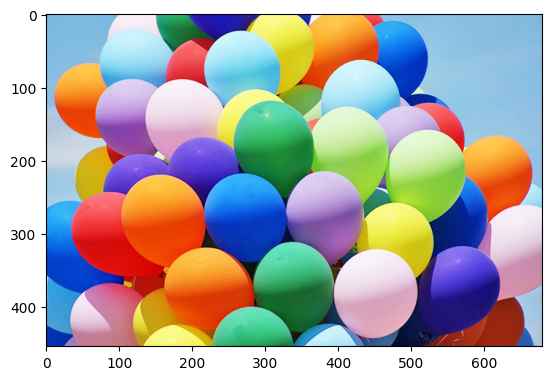

In [25]:
from torchvision.io import read_image
import matplotlib.pyplot as plt

file_name = "balloon_replacement.jpeg"
image = read_image(path=file_name)

plt.imshow(image.permute(1,2,0));